In [3]:
import pandas as pd
import numpy as np

In [4]:
train = pd.read_csv('train.csv',  dtype={'row_id':'int64','timestamp':'int64','user_id':'int32',
         'content_id':'int16',
         'content_type_id': 'boolean',
         'prior_question_elapsed_time' : 'int16',
         'answered_correctly':'int8',
         'prior_question_elapsed_time':'float64',
         'task_container_id':'int16',
         'user_answer' : 'int8',
         'prior_question_had_explanation': 'boolean'
     
         })

In [5]:
questions = pd.read_csv('questions.csv', sep=',')
lectures = pd.read_csv('lectures.csv', sep=',')

In [6]:
#записи с ответами на вопрос
userQuestions = train[train['content_type_id'] == 0].reset_index(drop=True)

In [7]:
#записи с посещением лекций
userLectures = train[train['content_type_id'] == 1].reset_index(drop=True)
userLectures

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,89,653762,2746,6808,True,14,-1,-1,NaN,False
1,117,10183847,5382,16736,True,21,-1,-1,NaN,False
2,212,1424348597,5382,30207,True,104,-1,-1,NaN,False
3,216,1425557777,5382,18545,True,121,-1,-1,NaN,False
4,295,405813029,8623,10540,True,59,-1,-1,NaN,False
...,...,...,...,...,...,...,...,...,...,...
1959027,101230063,132157858,2147482216,14325,True,38,-1,-1,NaN,False
1959028,101230195,1073593458,2147482216,21887,True,170,-1,-1,NaN,False
1959029,101230218,1240316256,2147482216,6808,True,193,-1,-1,NaN,False
1959030,101230220,1240470616,2147482216,27699,True,195,-1,-1,NaN,False


In [8]:
#получаем уникальное количество студентов
countStudents = train['user_id'].nunique()
countStudents

393656

In [9]:
#число студентов, смотревших лекции
watchedLecturesCount = userLectures['user_id'].nunique()
watchedLecturesCount

149606

In [10]:
#число студентов не смотревших лекции
notWatchedLecturesCount = countStudents - watchedLecturesCount 
notWatchedLecturesCount

244050

In [11]:
#Вопросы группируем по пользователю и агрегируем количество вопросов и ответы, чтобы посчитать на какой % был дан верный ответ
userStats = userQuestions[['user_id', 'answered_correctly']].groupby('user_id').agg({'answered_correctly':
                                  ['count', 'sum']})
#для удобства сбрасываем колонки до 1 уровня вложенности
userStats.columns = userStats.columns.droplevel()
#переименовывем колонки после агрегации
userStats = userStats.reset_index().rename(columns={'sum': 'answered_correctly', 'count': 'total_questions'})
#добавляем новый признак % правильных ответов и сохраняем
userStats['success_percent'] = userStats['answered_correctly']/userStats['total_questions'] * 100
userStats = userStats[['user_id', 'success_percent']].set_index('user_id')
display(userStats)
userStats.mean()

,success_percent
user_id,
115,69.565217
124,23.333333
2746,57.894737
5382,67.200000
8623,64.220183
...,...
2147470770,76.548673
2147470777,69.148936
2147481750,76.000000


success_percent    54.518327
dtype: float64

In [12]:
#пользователи которые ответили на все ответы верно
userStats[userStats['success_percent'] == 100.0]

,success_percent
user_id,
1880240,100.0
45312560,100.0
48102728,100.0
48251651,100.0
49510896,100.0
...,...
2096310880,100.0
2103184240,100.0
2119645200,100.0


In [13]:
#смотри на какое количество вопросов ответил каждый пользователь 
userQuestions[['user_id','content_id']].groupby('user_id').agg({'content_id':'count'}).rename(columns={'task_container_id':'count'}).describe()

,content_id
count,393656.000000
mean,252.177790
std,734.721108
min,1.000000
25%,30.000000
50%,40.000000
75%,154.000000
max,17609.000000


In [14]:
#посмотрим как влияют полученные разъяснения на последующие ответы:
userQuestions[['prior_question_had_explanation','answered_correctly']].dropna(
).groupby('prior_question_had_explanation').agg(
    {'answered_correctly':'mean'})



,answered_correctly
prior_question_had_explanation,
False,0.500629
True,0.673189


<Axes: xlabel='lectures'>

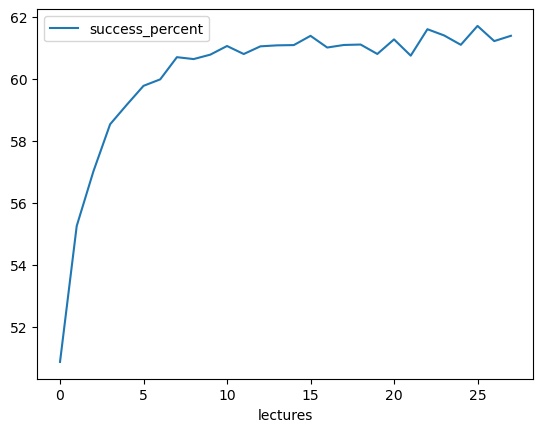

In [15]:
#аггрегируем все данные чтобы получить график зависимости правильных ответов от просмотренных лекций 
train['lectures'] = train['content_type_id'] == 1 #записываем в столбец запись о том является ли строка лекцией или строкой
train['questions'] = train['content_type_id'] == 0#чтобы затем была возможность получить суммы по этим данным
res = train.groupby('user_id').agg({
    'row_id':'count',
    'lectures':'sum',
    'questions':'sum',
    'answered_correctly':'sum'
}).reset_index()
res = res[
    (res['row_id'] > res['row_id'].quantile(0.1)) &  #отфильтровываем результаты с малым количеством строк
    (res['lectures'] < res['lectures'].quantile(0.95))#отфильтровываем слишком большое количеством лекций
]
res['success_percent'] = res['answered_correctly']/res['questions'] * 100
res.groupby('lectures').agg({
    'success_percent':'mean'
}).plot.line()

In [16]:
#изучим данные по вопросам и лекциям
display(lectures.head())
display(questions.head())

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [17]:
# посмотрим по каким тегам больше всего правильных ответов

userQuestionsJoined = userQuestions.set_index('content_id').join(questions.set_index('question_id'))

In [23]:
#df.assign(var1=df['var1'].str.split(',')).explode('var1')
resultsByTags = userQuestionsJoined[['answered_correctly','tags']].assign(tags=userQuestionsJoined['tags'].str.split(' ')).explode('tags').groupby('tags').agg({
    'answered_correctly':'mean'
}).dropna()

In [29]:
resultsByTags.sort_values('answered_correctly')

,answered_correctly
tags,
24,0.385725
23,0.438487
19,0.439938
151,0.493155
167,0.500432
...,...
40,0.813804
149,0.848015
130,0.853152


In [33]:
# посмотрим по каким группам больше всего правильных ответов
userQuestionsJoined[['answered_correctly','part']].groupby('part').agg({
    'answered_correctly':'mean'
}).dropna().sort_values('answered_correctly')

,answered_correctly
part,
5,0.610088
4,0.630998
7,0.659601
6,0.669388
3,0.701456
2,0.708694
1,0.745032
